In [12]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [13]:
hyperparam = {
    "vocab_size": 5000,
    "oov_tok":' <oov>',
    "max_length": 50,
    "trunc_type": 'post',
    "padding_type": 'post',
    "embedding_dim": 64
}

# Dataset input, pre-processing and transformation
df_train = pd.read_csv('./usercode/train.csv')
df_test = pd.read_csv('./usercode/test.csv')

df_train = df_train.sample(frac=1)

# shuffle -> numpy array -> tokenizer : fit on texts of train ->
#  tokenizer t: texts to sequence -> padding

train_data = df_train['text'].to_numpy()
test_data = df_test['text'].to_numpy()

tokenizer = Tokenizer(num_words=hyperparam['vocab_size'], oov_token=hyperparam['oov_tok'])
tokenizer.fit_on_texts(train_data)

train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

x_train = pad_sequences(train_sequences, maxlen=hyperparam['max_length'], padding=hyperparam['padding_type'],
                        truncating=hyperparam['trunc_type'])
x_test = pad_sequences(test_sequences, maxlen=hyperparam['max_length'], padding=hyperparam['padding_type'],
                        truncating=hyperparam['trunc_type'])

train_labels = pd.Categorical(df_train['category']).codes
test_labels = pd.Categorical(df_train['category']).codes

y_train = train_labels.reshape(-1, 1)
y_test = test_labels.reshape(-1, 1)

partial_x_train = x_train[:9000]
partial_y_train = y_train[:9000]

x_val = x_train[9000:]
y_val = y_train[9000:]

In [14]:
# 1. What does layers.Embedding Mean ?
# The Embedding layer can be understood as a lookup table 
# that maps from integer indices (which stand for specific words) to dense vectors (their embeddings)

# An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). 
# Instead of specifying the values for the embedding manually, 
# they are trainable parameters (weights learned by the model during training,
# in the same way a model learns weights for a dense layer). 

# When you create an Embedding layer, the weights for the embedding are randomly initialized
# (just like any other layer). During training, they are gradually adjusted via backpropagation.
# Once trained, the learned word embeddings will roughly encode similarities between words
# (as they were learned for the specific problem your model is trained on).

# Embed a 1,000 word vocabulary into 5 dimensions.
# 4th SQRT of 5000 ? = 70 Dimensions
embedding_layer = tf.keras.layers.Embedding(1000, 5)

# the result replaces each integer with the vector from the embedding table:
result = embedding_layer(tf.constant([1, 2, 3]))
result.numpy()

# 2. Layers.Bidirectional and LSTM ?

# 3. Layers.Dense ?

array([[-0.00473953, -0.00182111, -0.01561209, -0.03700006,  0.00134017],
       [-0.03263541, -0.01176772, -0.04060819, -0.03707446,  0.03699512],
       [ 0.00454749, -0.03496473, -0.0059546 , -0.0322712 ,  0.00176537]],
      dtype=float32)

#### Model Building

1. This model can be build as a tf.keras.Sequential.

2. The first layer is the encoder, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

    - This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a tf.keras.layers.Dense layer.
    
4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

    - The tf.keras.layers.Bidirectional wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

    - The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.

    - The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two layers.Dense do some final processing, and convert from this vector representation to a single logit as the classification output.

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(hyperparam['vocab_size'], hyperparam['embedding_dim']),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hyperparam['embedding_dim'])),
    tf.keras.layers.Dense(hyperparam['embedding_dim'], activation='relu'),
    tf.keras.layers.Dense(77, activation='softmax')

])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          320000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 77)                5005      
                                                                 
Total params: 399309 (1.52 MB)
Trainable params: 399309 (1.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
# Use this crossentropy loss function when there are two or more label classes. 
# We expect labels to be provided as integers

#  The shape of y_true is [batch_size] and the shape of y_pred is [batch_size, num_classes].
y_true = [1, 2] # (2)
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]] # (2, 3) -> 2 is batch size = 2, num classes = 3

loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
assert loss.shape == (2, )
print(y_true, y_pred, loss)

[1, 2] [[0.05, 0.95, 0], [0.1, 0.8, 0.1]] tf.Tensor([0.05129344 2.3025851 ], shape=(2,), dtype=float32)


In [6]:
# Use this crossentropy loss function when there are two or more label classes. 
# We expect labels to be provided in a one_hot representation.
# If you want to provide labels as integers, please use SparseCategoricalCrossentropy loss. 
# There should be num_classes floating point values per feature, i.e., 
# the shape of both y_pred and y_true are [batch_size, num_classes].

y_true = [[0, 1, 0], [0, 0, 1]] # (2, 3) -> 2 is batch size, 3 num of classes
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]

loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
assert loss.shape == (2,)
loss

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.05129331, 2.3025851 ], dtype=float32)>

In [20]:
# Use this cross-entropy loss for binary (0 or 1) classification applications

# Example 1: (batch_size = 1, number of samples = 4)
y_true = [0, 1, 0, 0] # Batch size is 1
y_pred = [-18.6, 0.51, 2.94, -12.8]
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.865458>

In [21]:
# Example 2: (batch_size = 2, number of samples = 4)
y_true = [[0, 1], [0, 0]]
y_pred = [[-18.6, 0.51], [2.94, -12.8]]

# Using default 'auto'/'sum_over_batch_size' reduction type.
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.865458>

In [22]:
num_epochs = 20
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(partial_x_train, partial_y_train,
                    epochs=num_epochs, validation_data=(x_val, y_val),
                    verbose=2)

Epoch 1/20
282/282 - 18s - loss: 3.9131 - accuracy: 0.0444 - val_loss: 3.3879 - val_accuracy: 0.1246 - 18s/epoch - 62ms/step
Epoch 2/20
282/282 - 14s - loss: 2.8342 - accuracy: 0.2018 - val_loss: 2.2800 - val_accuracy: 0.3141 - 14s/epoch - 49ms/step
Epoch 3/20
282/282 - 13s - loss: 1.9316 - accuracy: 0.4191 - val_loss: 1.6415 - val_accuracy: 0.5244 - 13s/epoch - 48ms/step
Epoch 4/20
282/282 - 14s - loss: 1.2892 - accuracy: 0.6166 - val_loss: 1.2822 - val_accuracy: 0.6261 - 14s/epoch - 49ms/step
Epoch 5/20
282/282 - 13s - loss: 0.8906 - accuracy: 0.7359 - val_loss: 1.0246 - val_accuracy: 0.7129 - 13s/epoch - 47ms/step
Epoch 6/20
282/282 - 14s - loss: 0.6842 - accuracy: 0.8037 - val_loss: 0.8747 - val_accuracy: 0.7557 - 14s/epoch - 50ms/step
Epoch 7/20
282/282 - 13s - loss: 0.5366 - accuracy: 0.8399 - val_loss: 0.8362 - val_accuracy: 0.7817 - 13s/epoch - 47ms/step
Epoch 8/20
282/282 - 13s - loss: 0.4297 - accuracy: 0.8769 - val_loss: 0.7918 - val_accuracy: 0.7787 - 13s/epoch - 46ms/step


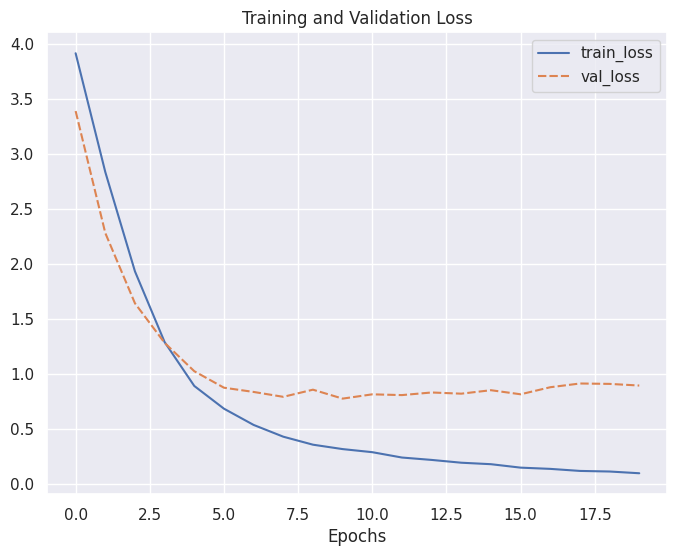

In [23]:
# Write the code to convert the training history to a pandas DataFrame here.

df_history = pd.DataFrame(history.history)
df_history.rename(columns={"loss":"train_loss"}, inplace=True)

# Write the code to plot training and validation loss curves here.
import seaborn as sns
sns.set(rc={"figure.figsize":(8, 6)})
my_plot = sns.lineplot(data=df_history[["train_loss", "val_loss"]])
my_plot.set_xlabel('Epochs')
my_plot.set_title("Training and Validation Loss")
plt.show()